# <img src="./resources/GA.png" width="25" height="25" /> <span style="color:Blue">DSI Capstone:  MTB Trail Recommender Engine</span> 
---
## <span style="color:Green">EDA</span>      

#### Ryan McDonald -General Assembly 



---

### Notebook Contents:

- [Reading the User Data](#intro)    
    - [Arizona User Data Cleaning](#cleanaz)
    - [Utah User Data Cleaning](#cleanut) 
- [Reading the Trail Data](#trail)
    - [Arizona Trail Data Cleaning](#trailaz)
        - [Arizona Imputation/OHE](#imputeaz)
    - [Utah Trail Data Cleaning](#trailut) 
        - [Utah Imputation/OHE](#imputeut)
- [Export to CSV- Arizona Trails](#saveaz)
- [Export to CSV- Utah Trails](#saveut)

**Imports**

In [19]:
# general processing, CSV manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


<a id='intro'></a>
## 1. Read Data- Arizona and Utah Trail Data

In [20]:
ut_trails = pd.read_csv('./data/trail_dashboard/ut_trails.csv')
ut_trails.head()

,trail_name,length,difficulty,longitude,latitude,trail_link,city,popularity,rating,local_club,...,land_manager,land_manager_site,tot_climb,tot_descent,ave_grade,max_grade,max_elevation,min_elevation,dog_policy,e_bike_policy
0,Thunder Mountain Trail #33098,8.1,INTERMEDIATE/DIFFICULT,37.702572,-112.279340,https://www.mtbproject.com/trail/1868735/thund...,"Panguitch, UT",1.000000,4.7,Trail Alliance of Southern Utah (TASU),...,USFS - Dixie National Forest Office,http://www.fs.usda.gov/dixie,689.0,1681.0,6.0,27.0,8263.0,7084.0,Off-leash,Unknown
1,Wasatch Crest,12.5,INTERMEDIATE/DIFFICULT,40.613847,-111.570911,https://www.mtbproject.com/trail/3654027/wasat...,"Alta, UT",0.998922,4.8,NaN,...,NaN,NaN,1084.0,2656.0,6.0,26.0,9882.0,7616.0,No Dogs,Not Allowed
2,Captain Ahab,4.2,DIFFICULT,38.518172,-109.618450,https://www.mtbproject.com/trail/648766/captai...,"Moab, UT",0.997845,4.7,NaN,...,NaN,NaN,326.0,981.0,6.0,23.0,4898.0,4034.0,Leashed,Not Allowed
3,Wire Mesa Loop,7.4,INTERMEDIATE/DIFFICULT,37.132839,-113.071259,https://www.mtbproject.com/trail/7021693/wire-...,"Springdale, UT",0.996767,4.6,NaN,...,NaN,NaN,428.0,415.0,2.0,12.0,4502.0,4326.0,Unknown,Allowed
4,Ramblin',3.3,INTERMEDIATE/DIFFICULT,38.637614,-109.784979,https://www.mtbproject.com/trail/7000569/ramblin,"Moab, UT",0.995690,4.7,NaN,...,NaN,NaN,195.0,398.0,3.0,12.0,5279.0,4971.0,Leashed,Not Allowed


In [21]:
az_trails = pd.read_csv('./data/trail_dashboard/az_trails.csv')
az_trails.head()

,trail_name,length,difficulty,longitude,latitude,trail_link,city,popularity,rating,local_club,...,land_manager,land_manager_site,tot_climb,tot_descent,ave_grade,max_grade,max_elevation,min_elevation,dog_policy,e_bike_policy
0,Hiline Trail,3.1,VERY DIFFICULT,34.804602,-111.771244,https://www.mtbproject.com/trail/593534/hiline...,Village of Oak Creek (Big Park),1.000000,4.7,Verde Valley Cyclists Coalition,...,USFS - Coconino National Forest Office,http://www.fs.usda.gov/coconino,326.0,695.0,6.0,35.0,4646.0,4086.0,Unknown,Unknown
1,Slim Shady Trail,2.6,INTERMEDIATE/DIFFICULT,34.790166,-111.765576,https://www.mtbproject.com/trail/593708/slim-s...,Village of Oak Creek (Big Park),0.998953,4.4,Verde Valley Cyclists Coalition,...,USFS - Coconino National Forest Office,http://www.fs.usda.gov/coconino,265.0,264.0,4.0,11.0,4464.0,4202.0,Unknown,Unknown
2,Mescal,2.4,INTERMEDIATE/DIFFICULT,34.906801,-111.824568,https://www.mtbproject.com/trail/4960011/mescal,West Sedona,0.997906,4.6,Verde Valley Cyclists Coalition,...,USFS - Coconino National Forest Office,http://www.fs.usda.gov/coconino,206.0,166.0,3.0,11.0,4710.0,4520.0,Unknown,Unknown
3,Chuckwagon,5.4,INTERMEDIATE,34.906632,-111.823948,https://www.mtbproject.com/trail/4960774/chuck...,West Sedona,0.996859,4.5,Verde Valley Cyclists Coalition,...,USFS - Coconino National Forest Office,http://www.fs.usda.gov/coconino,559.0,489.0,4.0,13.0,4679.0,4499.0,Unknown,Unknown
4,Tortolita Preserve Loop,9.7,INTERMEDIATE,32.439082,-111.098523,https://www.mtbproject.com/trail/6390787/torto...,Tortolita,0.995812,4.2,Sonoran Desert Mountain Bicyclists,...,"Pima County - Natural Resources, Parks and Rec...",http://webcms.pima.gov/government/natural_reso...,520.0,520.0,2.0,4.0,2804.0,2326.0,Unknown,Unknown


In [23]:
az_trails.dtypes

trail_name            object
length               float64
difficulty            object
longitude            float64
latitude             float64
trail_link            object
city                  object
popularity           float64
rating               float64
local_club            object
local_club_site       object
land_manager          object
land_manager_site     object
tot_climb            float64
tot_descent          float64
ave_grade            float64
max_grade            float64
max_elevation        float64
min_elevation        float64
dog_policy            object
e_bike_policy         object
dtype: object

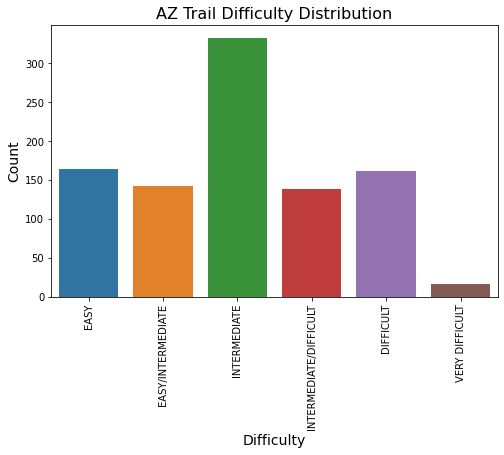

In [55]:
plt.figure(figsize = (8, 5))
sns.countplot(x='difficulty', data= az_trails,
              order=['EASY', 'EASY/INTERMEDIATE', 'INTERMEDIATE', 
                     'INTERMEDIATE/DIFFICULT', 'DIFFICULT', 
                     'VERY DIFFICULT'] )
plt.title('AZ Trail Difficulty Distribution', size = 16)
plt.ylabel('Count', size = 14)
plt.xlabel('Difficulty', size = 14)
plt.xticks(rotation = 90)

plt.show()

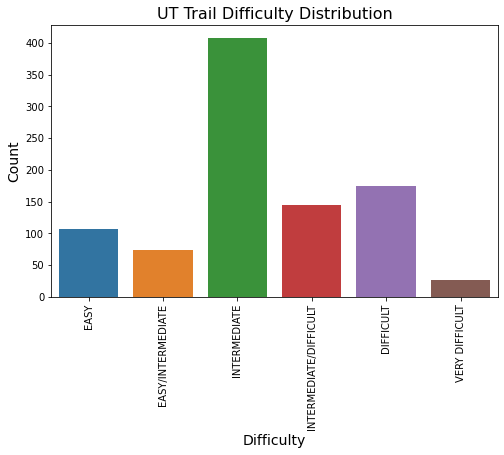

In [54]:
plt.figure(figsize = (8, 5))
sns.countplot(x='difficulty', data= ut_trails, 
              order=['EASY', 'EASY/INTERMEDIATE', 'INTERMEDIATE', 
                     'INTERMEDIATE/DIFFICULT', 'DIFFICULT', 
                     'VERY DIFFICULT'] )
plt.title('UT Trail Difficulty Distribution', size = 16)
plt.ylabel('Count', size = 14)
plt.xlabel('Difficulty', size = 14)
plt.xticks(rotation = 90)

plt.show()

The majority of trails in Arizona are rated intermediate.

In [15]:
def biggest_adj_product(number, span):
   
    # storing length of number
    n_digits = len(str(number))
    
    # storing string 'version' of the input number
    number_str = str(number)
    
    # storing biggest product seen so far
    biggest_product = 0
    
    # start at zero
    # go up to length - span so we only consider
    # segments of len(span)
    for ix in range(0, n_digits-span+1):
        
        # convert back to a list of numbers
        digits = [int(each) for each in number_str[ix:ix+span]]
        
        # running product instantiated at 1 -
        # don't want zero!
        running_product = 1
        
        # calculate running product
        for d in digits:
            running_product = running_product * d
        
        # check if running product bigger than biggest product
        # seen previously
        if running_product > biggest_product:
            
            # if so, overwrite it
            biggest_product = running_product
    
    # don't forget to return it!
    return biggest_product

In [1]:
# print out all lengths of 'span'
for ix in range(0, n_digits-span+1):
# for ix in range(0, n_digits):
    print(number_str[ix:ix+span])

7316717653133
3167176531330
1671765313306
6717653133062
7176531330624
1765313306249
7653133062491
6531330624919
5313306249192
3133062491922
1330624919225
3306249192251
3062491922511
0624919225119
6249192251196
2491922511967
4919225119674
9192251196744
1922511967442
9225119674426
2251196744265
2511967442657
5119674426574
1196744265747
1967442657474
9674426574742
6744265747423
7442657474235
4426574742355
4265747423553
2657474235534
6574742355349
5747423553491
7474235534919
4742355349194
7423553491949
4235534919493
2355349194934
3553491949349
5534919493496
5349194934969
3491949349698
4919493496983
9194934969835
1949349698352
9493496983520
4934969835203
9349698352031
3496983520312
4969835203127
9698352031277
6983520312774
9835203127745
8352031277450
3520312774506
5203127745063
2031277450632
0312774506326
3127745063262
1277450632623
2774506326239
7745063262395
7450632623957
4506326239578
5063262395783
0632623957831
6326239578318
3262395783180
2623957831801
6239578318016
2395783180169
395783